# Nettoyage des données

In [14]:
# Import des bibliothèques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer


In [3]:
# Import du dataset

df = pd.read_csv('dataset/housing_data_italy_august2022.csv')

## Suppressions des colonnes inutiles


Nous avons précédemment identifié certaines colonnes qui n'apportent aucune information utile :
- id
- timestamp

Nous avons identifié des colonnes qui contiennent toutes la même information et sont donc inutiles :
- availability
- status

Nous avons identifié des colonnes dont les données ne sont pas exploitables :
- title

Nous conserverons la colonne heating comme catégorie binaire

In [4]:
print(f"Colonnes initiales : {df.columns} ")

useless_columns = [
    'id',
    'timestamp',
    'title',
    'availability',
    'status'
]

df.drop(columns=useless_columns, inplace=True)

print(f"Colonnes après suppression : {df.columns} ")

Colonnes initiales : Index(['id', 'timestamp', 'location', 'title', 'price', 'n_rooms', 'floor',
       'mq', 'n_bathrooms', 'year_of_construction', 'availability',
       'energy_class', 'status', 'heating', 'has_garage', 'has_terrace',
       'has_garden', 'has_balcony', 'has_fireplace', 'has_alarm',
       'has_air_conditioning', 'has_pool', 'has_parking', 'has_elevator',
       'is_furnished'],
      dtype='object') 
Colonnes après suppression : Index(['location', 'price', 'n_rooms', 'floor', 'mq', 'n_bathrooms',
       'year_of_construction', 'energy_class', 'heating', 'has_garage',
       'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace',
       'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking',
       'has_elevator', 'is_furnished'],
      dtype='object') 


## Gestion des valeurs manquantes

Rappel des colonnes avec valeurs manquantes :

### > de 50% de valuers manquantes
Aucune

### Entre 20% et 50% de valeurs manquantes
- floor : 151044 données présentes (67.61%)
- n_rooms : 163086 données présentes (73.00%)

Nous avons ici des données avec un manque important.
- Dans le cas de l'étage 'floor', un tiers des données sont manquantes. Nous avons également vu que la distribution pouvait poser problème. En effet, si trois quarts des données sont 1 et 2, le maximum est au-delà de 50. De plus, en terme d'influence, si l'on peut considérer généralement une moins-value pour les logements au rez de chaussée, la différence entre étage supérieure est quasi nulle. Ainsi, la variation n'est pas linéaire (au sens ou la différence entre l'étage 1 et 2 et beaucoup plus importante qu'entre les étage 4 et 7 par exemple. Nous choisirons donc de supprimer cette colonne.
- Le cas du nombre de pièce sera traité différemment car il nous semble particulièrement important (même si il peut être légèrement redondant avec la surface en m2). Nous choisirons donc une imputation des valeurs manquantes.

### < 20% de valeurs manquantes
- Price : 184293 données présentes (82.49%)
- n_bathrooms : 209012 données présentes (93.56%)
- mq : 219375 données présentes (98.19%)
- energy_class : 222730 données présentes (99.70%)
- year_of_construction : 223399 données présentes (100.00%)

Dans les cas de 'n_bathrooms', 'mq', 'energy_class', 'year_of_construction', les valeurs manquantes étant peu nombreuses, nous choisirons systématiquement l'imputation des valeurs manquantes.

En revanche, la variable 'price' étant la valeur cible (label "y") et son taux de valeurs manquantes approchant les 20 %, nous comparerons 2 approches :
- l'une consistera à supprimer les lignes dont le prix est manquant (approche qualitative : moins de données mais tous les prix sont réels)
- l'autre consistera à imputer des valeurs synthétiques aux valeurs manquantes (approche plus quantitative : plus de données mais certaines valeurs sont synthétiques)



In [5]:
deleted_column = [
    'floor'
]

df.drop(columns=deleted_column, inplace=True)

print(f"Colonnes après suppression : {df.columns} ")

Colonnes après suppression : Index(['location', 'price', 'n_rooms', 'mq', 'n_bathrooms',
       'year_of_construction', 'energy_class', 'heating', 'has_garage',
       'has_terrace', 'has_garden', 'has_balcony', 'has_fireplace',
       'has_alarm', 'has_air_conditioning', 'has_pool', 'has_parking',
       'has_elevator', 'is_furnished'],
      dtype='object') 


In [6]:
# Copie d'un dataframe avec seulement les lignes ayant un prix
df_small = df[df['price'].notna()].copy()

# Affichage du nombre de lignes dans chaque DataFrame
print(f"Nombre de lignes dans le DataFrame original       : {len(df)}")
print(f"Nombre de lignes sans valeurs manquantes pour 'price' : {len(df_small)}")

Nombre de lignes dans le DataFrame original       : 223409
Nombre de lignes sans valeurs manquantes pour 'price' : 184293


On va refaire la matrice de corrélation avec les lignes restantes :


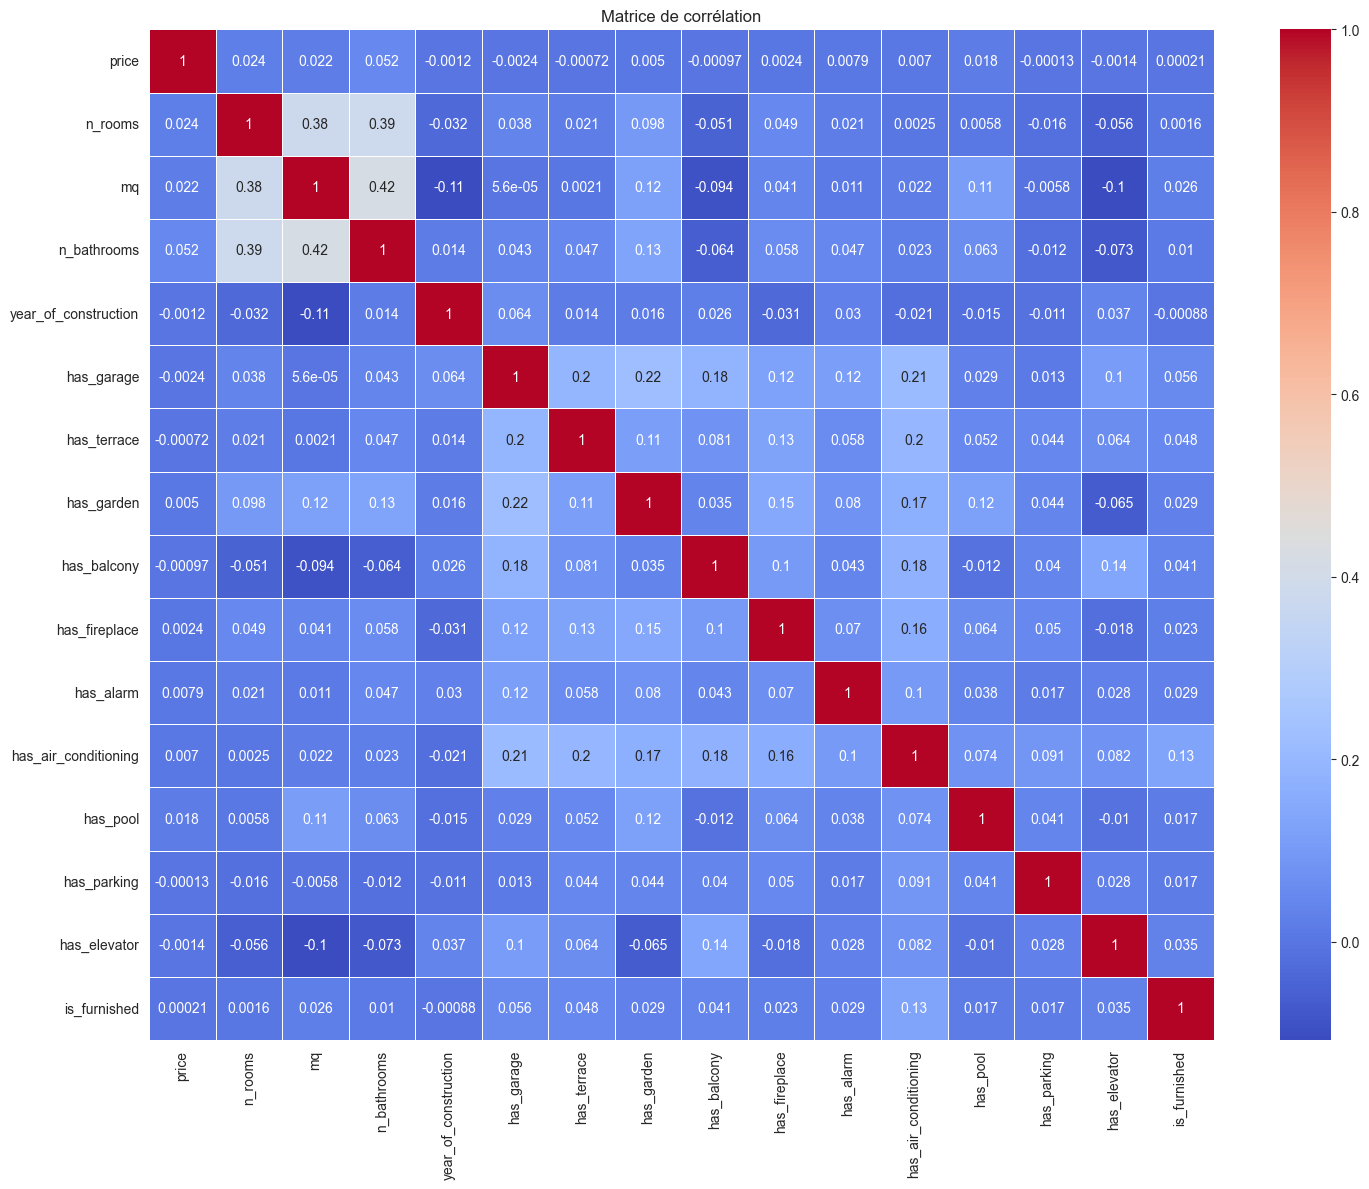

In [7]:
# Sélection des colonnes numériques uniquement
numeric_df = df.select_dtypes(include=['number'])

# Calcul de la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Affichage avec seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.savefig('output/correlation_matrix.png')
plt.show()
plt.close()

## Traitement des outliers



Détection des outliers avec IQR (3xIQR)
Outliers détectés : 18209
Nouvelles dimensions : 2


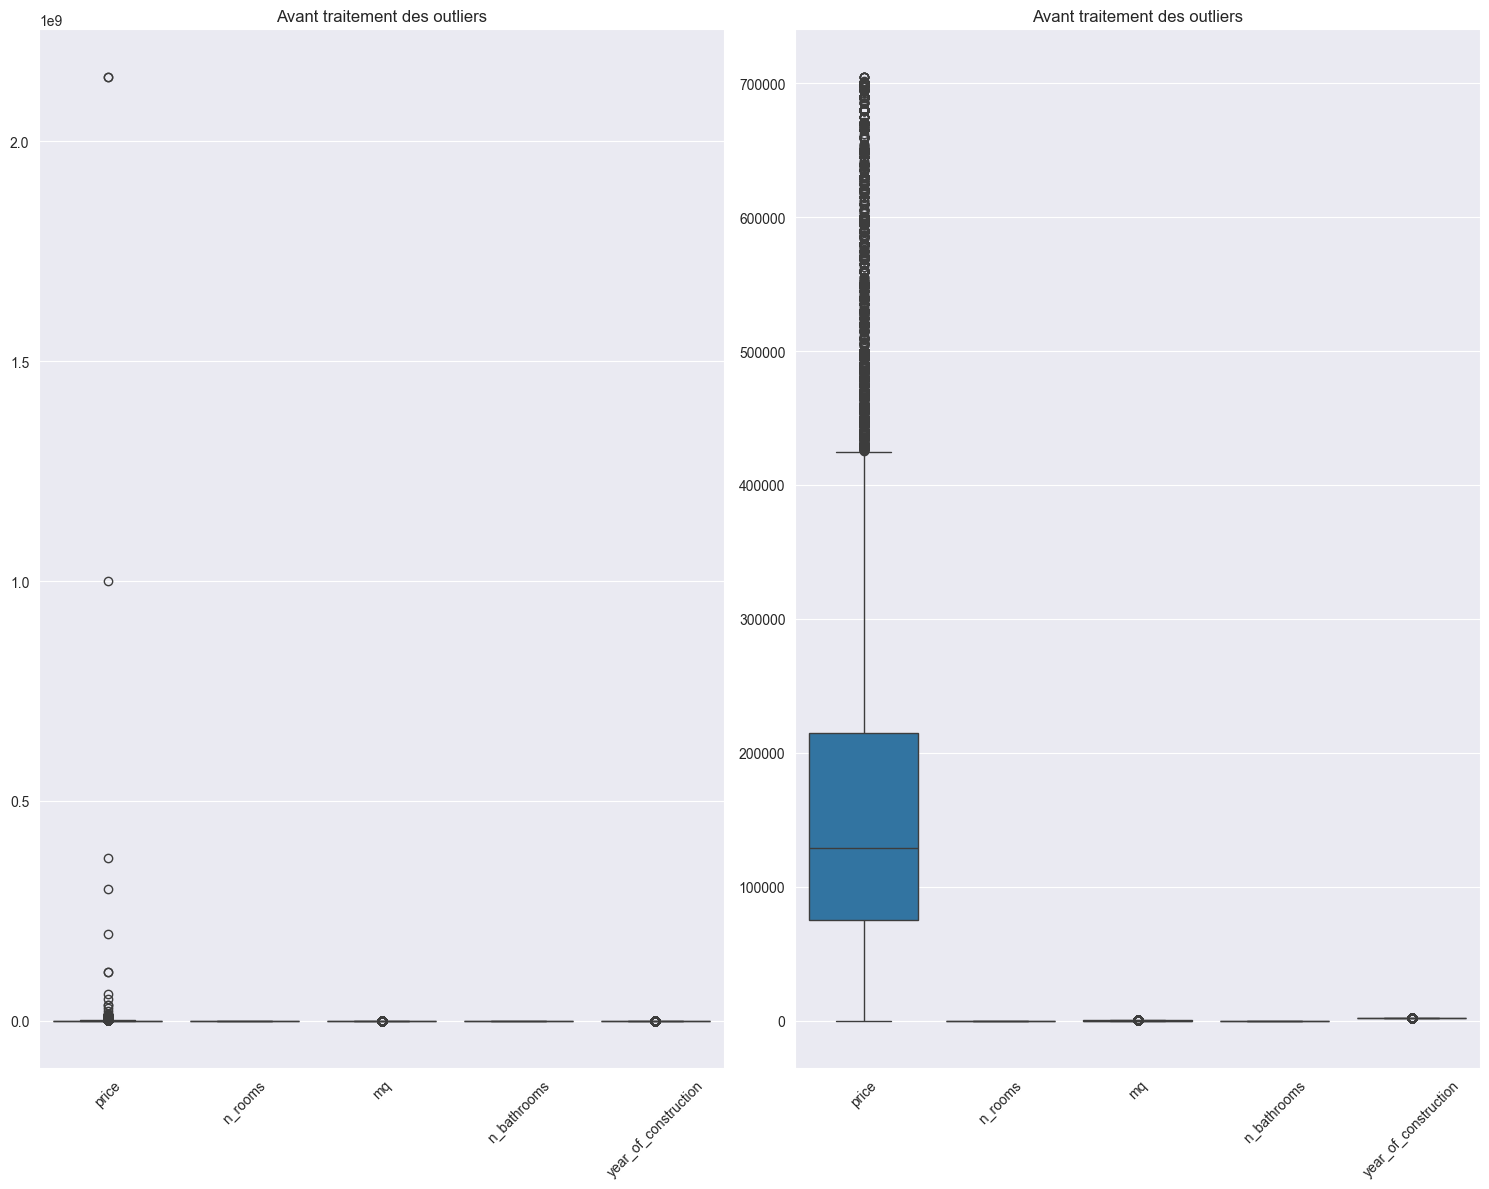

In [28]:
print("\nDétection des outliers avec IQR (3xIQR)")
Q1 = df[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']].quantile(0.25)
Q3 = df[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']].quantile(0.75)
IQR = Q3 - Q1
outlier_limit = IQR*3

outlier_mask = ((df[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']] < (Q1 - outlier_limit)) | (df[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']] > (Q3 + outlier_limit))).any(axis=1)

df_ftr = df[~outlier_mask]
print(f"Outliers détectés : {outlier_mask.sum()}")
print(f"Nouvelles dimensions : {len(df_ftr.shape)}")


#Visualisation avec un boxplot
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_ftr[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/outliers_boxplot.png')
plt.show()
plt.close()


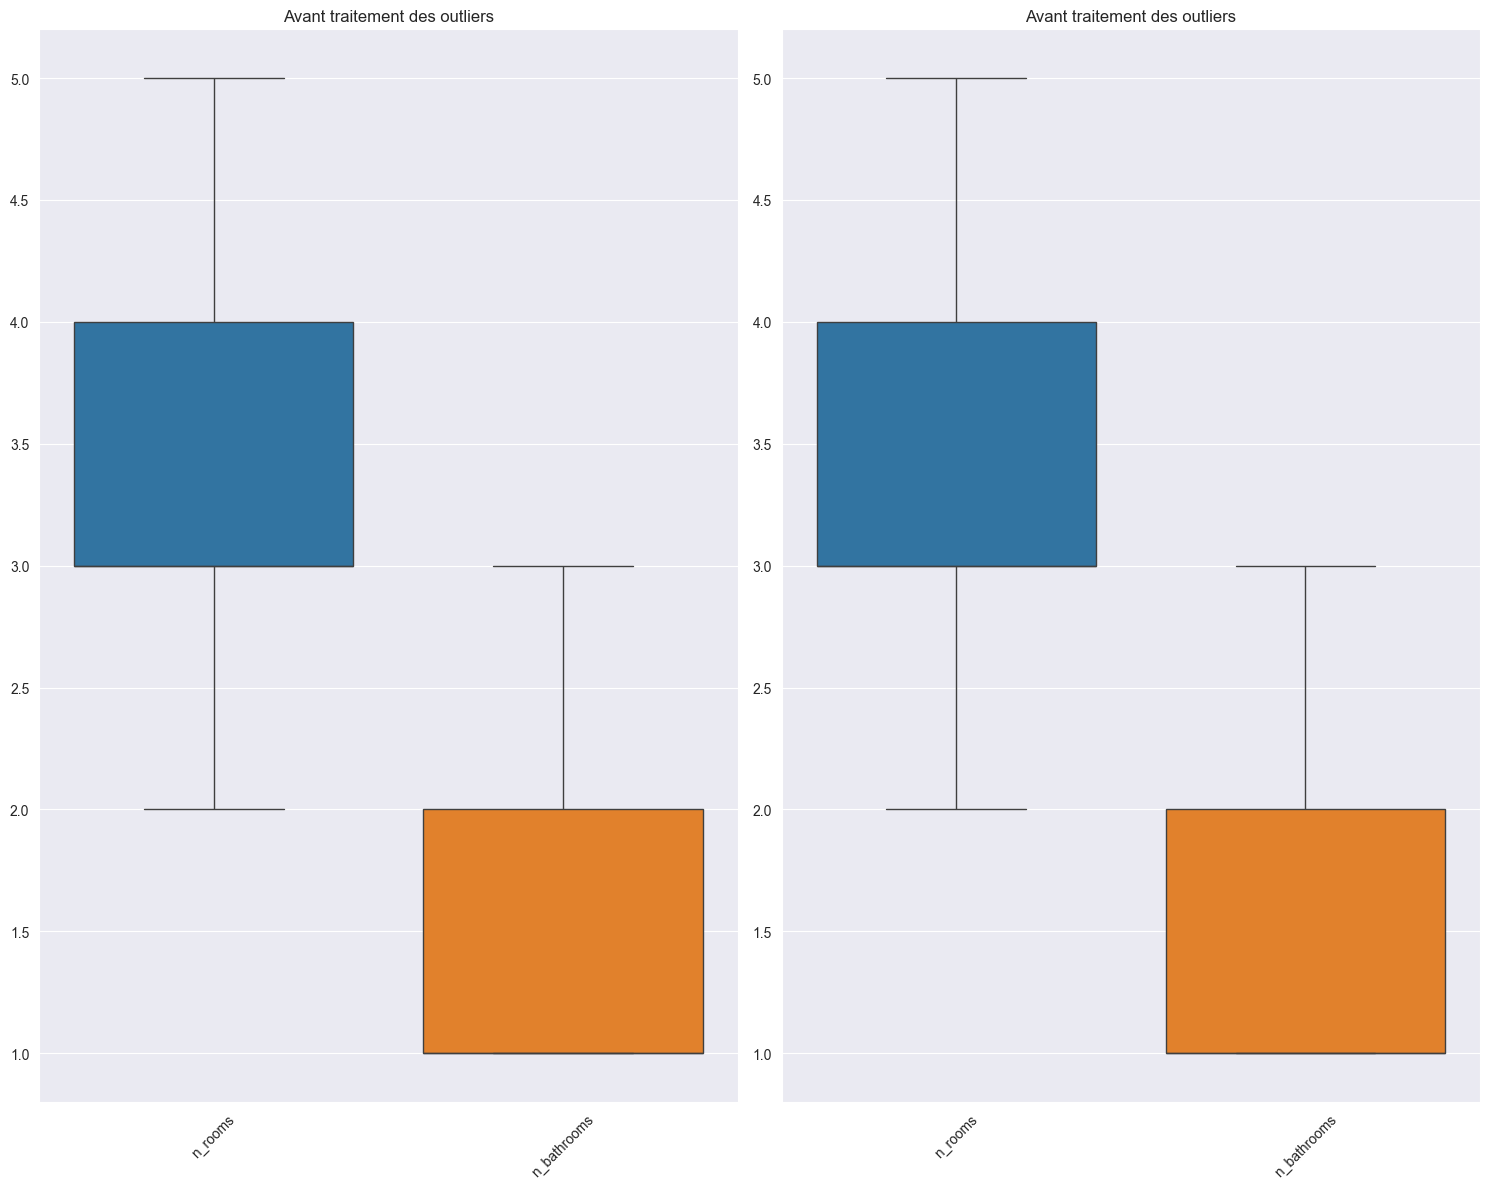

In [29]:
#Visualisation n_rooms & n_bathrooms
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['n_rooms',  'n_bathrooms']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_ftr[['n_rooms', 'n_bathrooms']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/outliers_boxplot2.png')
plt.show()
plt.close()

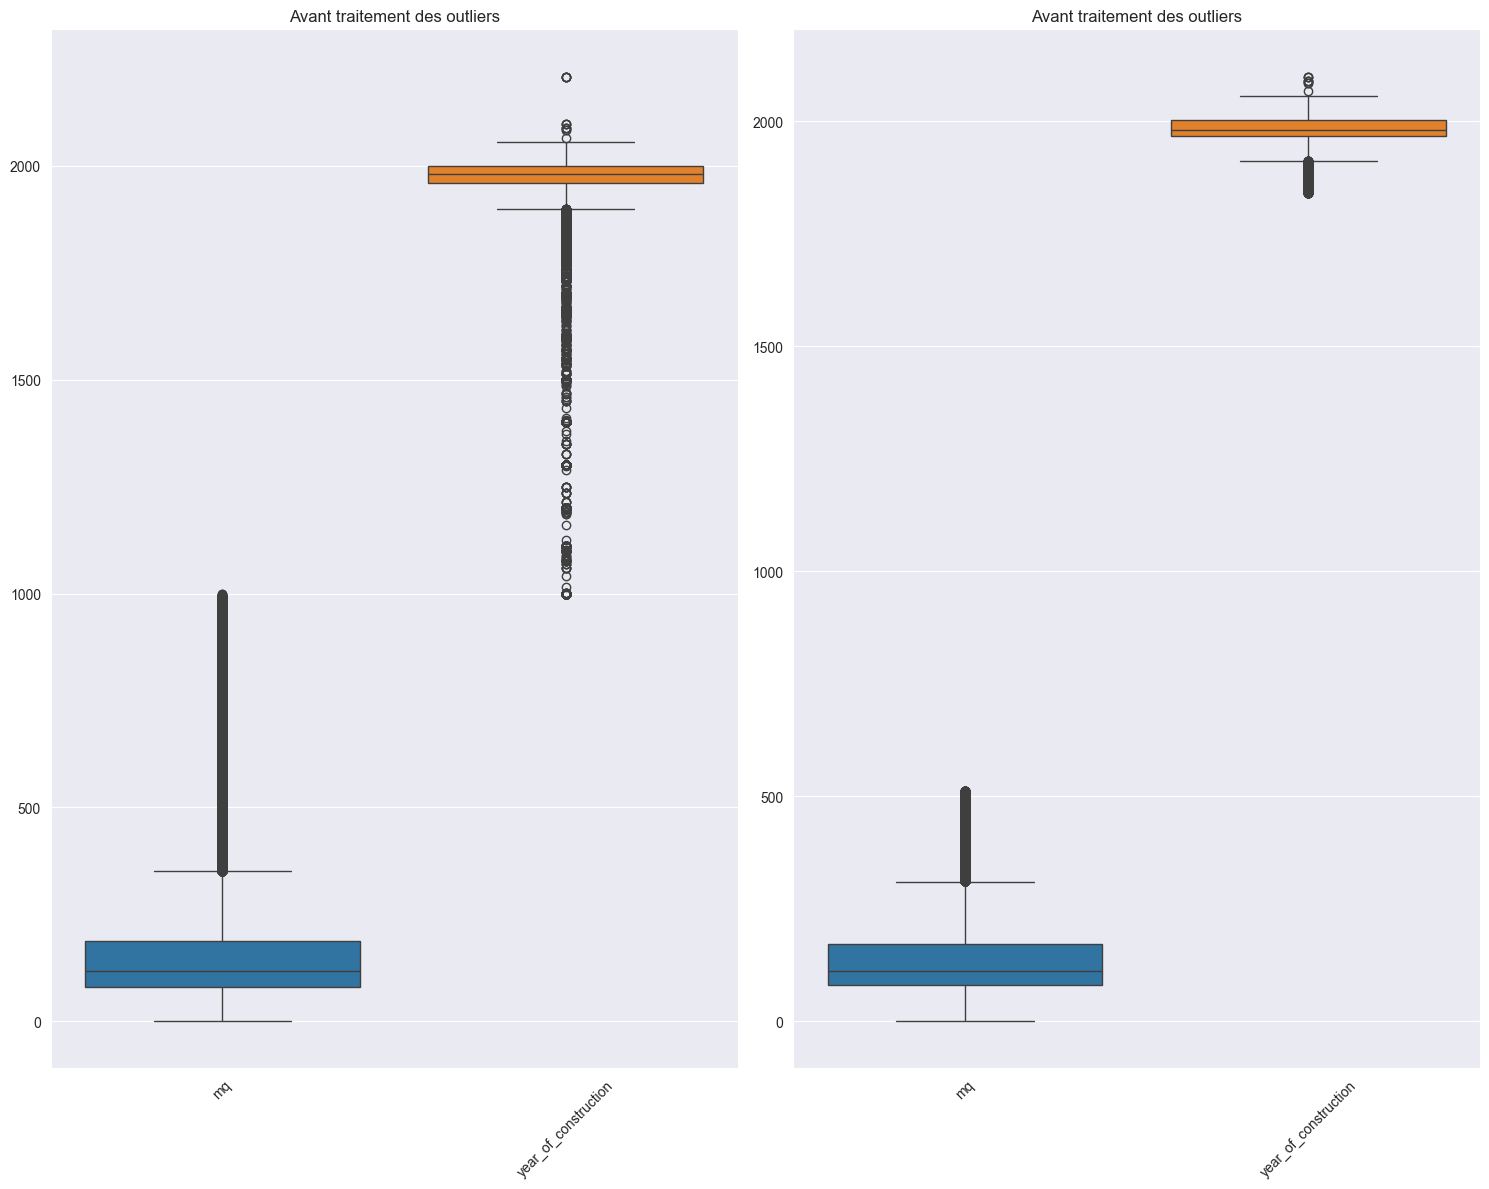

In [30]:
#Visualisation mq & year
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
sns.boxplot(data=df[['mq','year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_ftr[[ 'mq',  'year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/outliers_boxplot3.png')
plt.show()
plt.close()

On les traite également sur le dataset 'small'


Détection des outliers avec IQR (3xIQR)
Outliers détectés : 15828
Nouvelles dimensions : 2


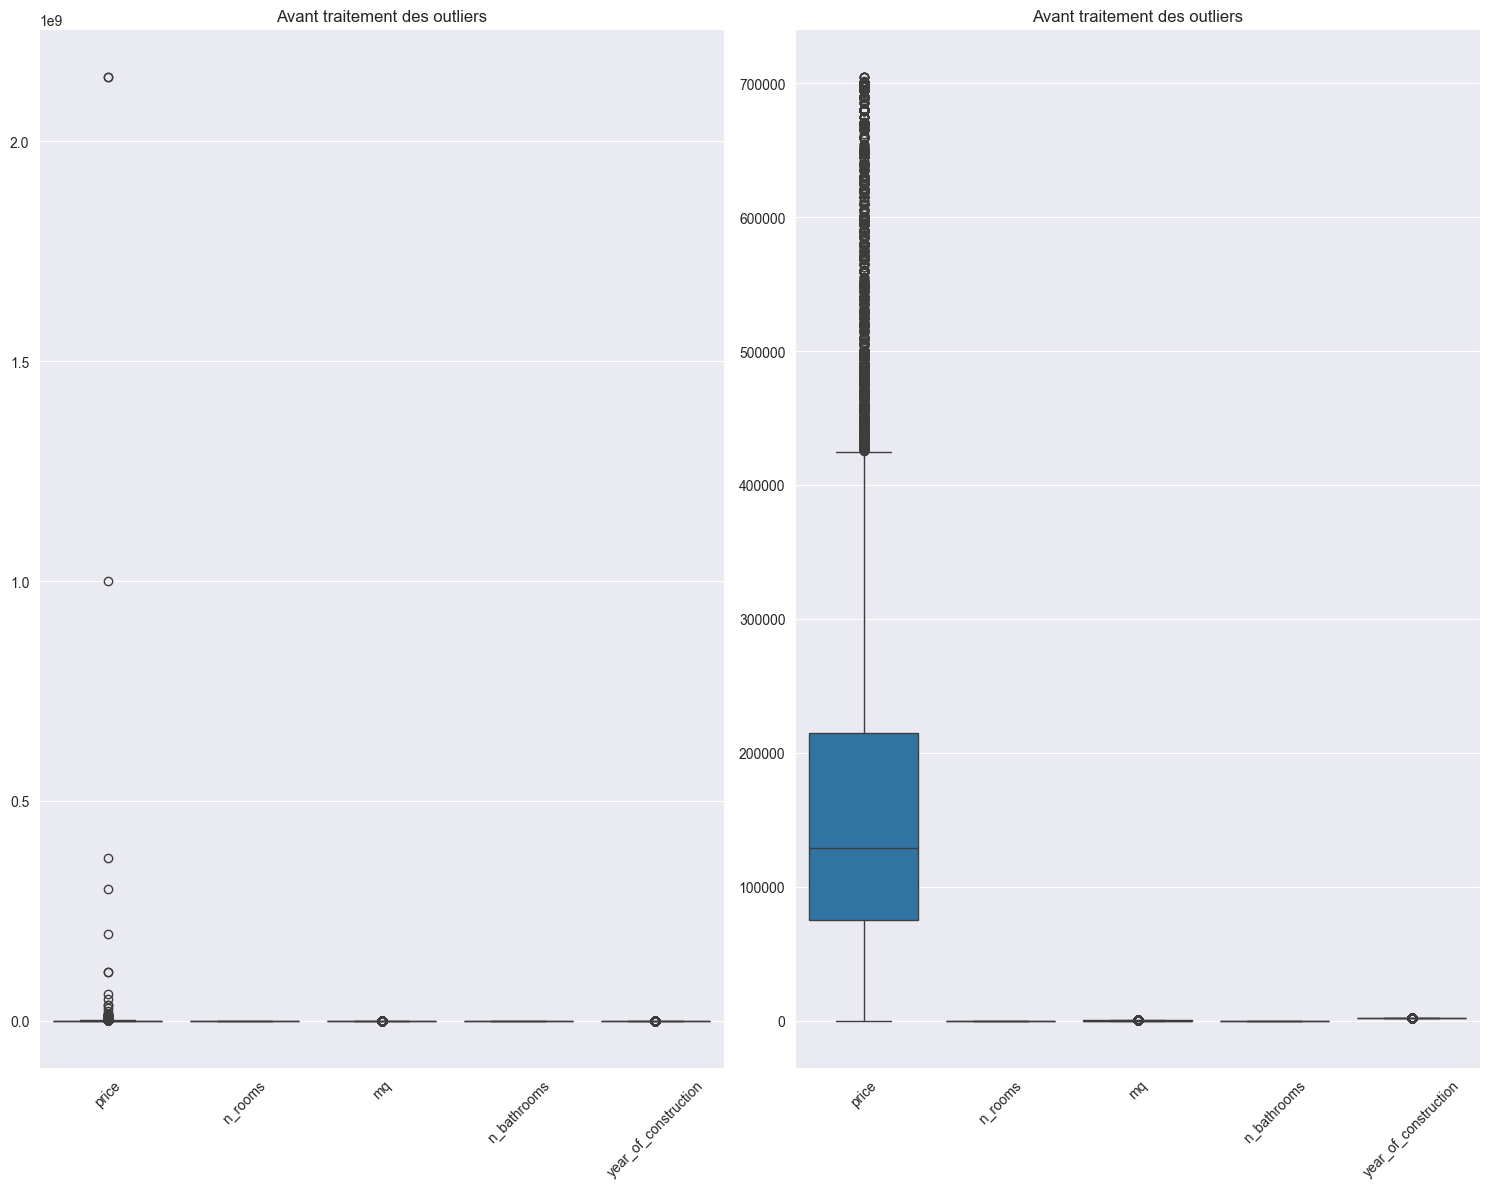

In [31]:
print("\nDétection des outliers avec IQR (3xIQR)")
Q1 = df_small[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']].quantile(0.25)
Q3 = df_small[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']].quantile(0.75)
IQR = Q3 - Q1
outlier_limit = IQR*3

outlier_mask = ((df_small[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']] < (Q1 - outlier_limit)) | (df_small[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']] > (Q3 + outlier_limit))).any(axis=1)

df_small_ftr = df_small[~outlier_mask]
print(f"Outliers détectés : {outlier_mask.sum()}")
print(f"Nouvelles dimensions : {len(df_small_ftr.shape)}")


#Visualisation avec un boxplot
plt.figure(figsize=(15, 12))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_small[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_small_ftr[['price', 'n_rooms', 'mq', 'n_bathrooms', 'year_of_construction']])
plt.title('Avant traitement des outliers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('output/outliers_boxplot4.png')
plt.show()
plt.close()

Note : Il serait intéressant de détecter les outliers avec la méthode du Z-Score et de comparer les résultats. Le manque de temps ne nous le permet malheureusement pas.

### Imputation des données manquantes

Afin d'imputer les données manquantes, nous choisiront la méthode des k plus proches voisins (knn).
Nous choisirons de retenir le nombre de voisins à 3 et à 10.
Il serait bien sûr intéressant d'essayer d'autres méthodes (imputation simple, différents nombres de voisins...) mais nous nous contenterons ici de 2 paramétrages. Combinés à nos 2 jeux de données, cela fera 4 jeux de données différentes à tester avec les différents modèles.


### 4 jeux de données :
df1 : jeu qui conserve les données à prix vide avec imputation knn de paramètre 3.
df2 : jeu qui conserve les données à prix vide avec imputation knn de paramètre 10.
df3 : jeu qui ne conserve pas les données à prix vide avec imputation knn de paramètre 3.
df4 : jeu qui ne conserve pas les données à prix vide avec imputation knn de paramètre 10.

De nombreuses autres options auraient pu être retenues mais cela aurait considérablement augmenté le nombre de jeux de données différentes.

### df1

In [23]:
print(" Jeu : df1")
print(" Base : df")
print(" imputation : knn 3")

imputer = KNNImputer(n_neighbors=3)
numeric_cols = ['price', 'n_rooms', 'mq', 'n_bathrooms',
       'year_of_construction']
df1 = df_ftr.copy()
df1[numeric_cols] = imputer.fit_transform(df1[numeric_cols])

print("\n Avant imputation : ")
print(df_ftr[numeric_cols])

print("\n Après imputation : ")
print(df1[numeric_cols])

 Jeu : df1
 Base : df
 imputation : knn 3

 Avant imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223407       NaN      3.0    NaN          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[205200 rows x 5 columns]

 Après imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0  

Jeu : df1
 Base : df
 imputation : knn 3

 Avant imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223407       NaN      3.0    NaN          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[205200 rows x 5 columns]

 Après imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0           1989.000000
1       120000.0      4.0  190.0          2.0           1940.000000
2        55000.0      2.0   85.0          1.0           1990.000000
3       130000.0      4.0  319.0          1.0           1980.666667
4        30000.0      3.0  143.0          2.0           1968.333333
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0           1994.000000
223405  130000.0      4.0  190.0          2.0           1994.000000
223406  210000.0      3.0   80.0          1.0           1920.000000
223407  190000.0      3.0  206.0          1.0           1920.000000
223408  220000.0      3.0  111.0          2.0           1920.000000

[205200 rows x 5 columns]

### df2

In [24]:
print(" Jeu : df2")
print(" Base : df")
print(" imputation : knn 10")

imputer = KNNImputer(n_neighbors=10)
numeric_cols = ['price', 'n_rooms', 'mq', 'n_bathrooms',
       'year_of_construction']
df2 = df_ftr.copy()
df2[numeric_cols] = imputer.fit_transform(df2[numeric_cols])

print("\n Avant imputation : ")
print(df_ftr[numeric_cols])

print("\n Après imputation : ")
print(df2[numeric_cols])

 Jeu : df2
 Base : df
 imputation : knn 10

 Avant imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223407       NaN      3.0    NaN          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[205200 rows x 5 columns]

 Après imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0 

 Jeu : df2
 Base : df
 imputation : knn 10

 Avant imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223407       NaN      3.0    NaN          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[205200 rows x 5 columns]

 Après imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                1990.3
1       120000.0      4.0  190.0          2.0                1970.5
2        55000.0      2.0   85.0          1.0                1983.2
3       130000.0      4.0  319.0          1.0                1982.3
4        30000.0      3.7  143.0          2.0                1973.5
...          ...      ...    ...          ...                   ...
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223407  144600.0      3.0  106.4          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[205200 rows x 5 columns]

Note : on voit que les résultats changent considérablement!
ex sur l'avant-dernière ligne : 144600 vs 190000 et 106,4 vs 206 !
Il serait très intéressant de diversifier encore ce paramètre si on en avait le temps!

### df3

In [25]:
print(" Jeu : df3")
print(" Base : df_small")
print(" imputation : knn 3")

imputer = KNNImputer(n_neighbors=3)
numeric_cols = ['price', 'n_rooms', 'mq', 'n_bathrooms',
       'year_of_construction']
df3 = df_small_ftr.copy()
df3[numeric_cols] = imputer.fit_transform(df3[numeric_cols])

print("\n Avant imputation : ")
print(df_small_ftr[numeric_cols])

print("\n Après imputation : ")
print(df3[numeric_cols])

 Jeu : df3
 Base : df_small
 imputation : knn 3

 Avant imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223403  269000.0      NaN  230.0          2.0                1960.0
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[168465 rows x 5 columns]

 Après imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_constructi

 Jeu : df3
 Base : df_small
 imputation : knn 3

 Avant imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223403  269000.0      NaN  230.0          2.0                1960.0
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[168465 rows x 5 columns]

 Après imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0           1968.000000
1       120000.0      4.0  190.0          2.0           1959.000000
2        55000.0      2.0   85.0          1.0           1965.333333
3       130000.0      4.0  319.0          1.0           1941.666667
4        30000.0      4.0  143.0          2.0           1916.333333
...          ...      ...    ...          ...                   ...
223403  269000.0      4.0  230.0          2.0           1960.000000
223404  100000.0      2.0   50.0          1.0           1994.000000
223405  130000.0      4.0  190.0          2.0           1994.000000
223406  210000.0      3.0   80.0          1.0           1920.000000
223408  220000.0      3.0  111.0          2.0           1920.000000

[168465 rows x 5 columns]

### df4

In [26]:
print(" Jeu : df4")
print(" Base : df_small")
print(" imputation : knn 10")

imputer = KNNImputer(n_neighbors=10)
numeric_cols = ['price', 'n_rooms', 'mq', 'n_bathrooms',
       'year_of_construction']
df4 = df_small_ftr.copy()
df4[numeric_cols] = imputer.fit_transform(df4[numeric_cols])

print("\n Avant imputation : ")
print(df_small_ftr[numeric_cols])

print("\n Après imputation : ")
print(df4[numeric_cols])

 Jeu : df4
 Base : df_small
 imputation : knn 10

 Avant imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223403  269000.0      NaN  230.0          2.0                1960.0
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[168465 rows x 5 columns]

 Après imputation : 
           price  n_rooms     mq  n_bathrooms  year_of_construct

 Jeu : df4
 Base : df_small
 imputation : knn 10

 Avant imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                   NaN
1       120000.0      4.0  190.0          2.0                   NaN
2        55000.0      2.0   85.0          1.0                   NaN
3       130000.0      4.0  319.0          1.0                   NaN
4        30000.0      NaN  143.0          2.0                   NaN
...          ...      ...    ...          ...                   ...
223403  269000.0      NaN  230.0          2.0                1960.0
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[168465 rows x 5 columns]

 Après imputation :
           price  n_rooms     mq  n_bathrooms  year_of_construction
0        46000.0      4.0   85.0          2.0                1970.7
1       120000.0      4.0  190.0          2.0                1965.5
2        55000.0      2.0   85.0          1.0                1969.9
3       130000.0      4.0  319.0          1.0                1938.0
4        30000.0      4.2  143.0          2.0                1931.0
...          ...      ...    ...          ...                   ...
223403  269000.0      4.3  230.0          2.0                1960.0
223404  100000.0      2.0   50.0          1.0                1994.0
223405  130000.0      4.0  190.0          2.0                1994.0
223406  210000.0      3.0   80.0          1.0                1920.0
223408  220000.0      3.0  111.0          2.0                1920.0

[168465 rows x 5 columns]

Note : energy_class n'a pas été imputé. Il faudra d'abord convertir les classes énergétiques en données numériques (ce qui sera fait durant la prochaine étape) avant de procéder à l'imputation.

## Sauvegarde des datasets pour réutilisation dans le prochain jupyter notebook

In [27]:
df1.to_csv('dataset/df1.csv', index=False)
df2.to_csv('dataset/df2.csv', index=False)
df3.to_csv('dataset/df3.csv', index=False)
df4.to_csv('dataset/df4.csv', index=False)